In [1]:
import pandas as pd
import numpy as np
import pickle

import warnings
warnings.filterwarnings('ignore')

#Scikit-Learn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Evaluation
from sklearn.metrics import r2_score # R2
from sklearn.metrics import mean_squared_error # RMSE

# Data Visualisation
import matplotlib.pyplot as plt 
import seaborn as sns


In [2]:
#  Import and read Australian Vehicle Prices.csv
Vehicleprices_df = pd.read_csv("Resources/Australian_Vehicle_Prices.csv")
Vehicleprices_df.head()

,Brand,Year,Model,Car/Suv,Title,UsedOrNew,Transmission,Engine,DriveType,FuelType,FuelConsumption,Kilometres,ColourExtInt,Location,CylindersinEngine,BodyType,Doors,Seats,Price
0,Ssangyong,2022.0,Rexton,Sutherland Isuzu Ute,2022 Ssangyong Rexton Ultimate (awd),DEMO,Automatic,"4 cyl, 2.2 L",AWD,Diesel,8.7 L / 100 km,5595,White / Black,"Caringbah, NSW",4 cyl,SUV,4 Doors,7 Seats,51990
1,MG,2022.0,MG3,Hatchback,2022 MG MG3 Auto Excite (with Navigation),USED,Automatic,"4 cyl, 1.5 L",Front,Premium,6.7 L / 100 km,16,Black / Black,"Brookvale, NSW",4 cyl,Hatchback,5 Doors,5 Seats,19990
2,BMW,2022.0,430I,Coupe,2022 BMW 430I M Sport,USED,Automatic,"4 cyl, 2 L",Rear,Premium,6.6 L / 100 km,8472,Grey / White,"Sylvania, NSW",4 cyl,Coupe,2 Doors,4 Seats,108988
3,Mercedes-Benz,2011.0,E500,Coupe,2011 Mercedes-Benz E500 Elegance,USED,Automatic,"8 cyl, 5.5 L",Rear,Premium,11 L / 100 km,136517,White / Brown,"Mount Druitt, NSW",8 cyl,Coupe,2 Doors,4 Seats,32990
4,Renault,2022.0,Arkana,SUV,2022 Renault Arkana Intens,USED,Automatic,"4 cyl, 1.3 L",Front,Unleaded,6 L / 100 km,1035,Grey / Black,"Castle Hill, NSW",4 cyl,SUV,4 Doors,5 Seats,34990


In [3]:
# Copying original dataset
dataset = Vehicleprices_df.copy()
dataset.tail()

,Brand,Year,Model,Car/Suv,Title,UsedOrNew,Transmission,Engine,DriveType,FuelType,FuelConsumption,Kilometres,ColourExtInt,Location,CylindersinEngine,BodyType,Doors,Seats,Price
16729,Toyota,2014.0,Alphard,SYC Cars,2014 Toyota Alphard,USED,Automatic,-,Front,Unleaded,-,66000,Grey / -,"Rocklea, QLD",-,Commercial,7 Seats,NaN,29500
16730,Mercedes-Benz,2012.0,S-Class,USED Dealer ad,2012 Mercedes-Benz S-Class CDI BlueTEC,USED,Automatic,-,Rear,Diesel,-,117432,Silver / -,"Port Melbourne, VIC",-,NaN,NaN,NaN,39888
16731,Suzuki,2022.0,Vitara,Bremer Suzuki - New,2022 Suzuki Vitara 1.6L,DEMO,Automatic,"4 cyl, 1.6 L",Front,Unleaded,6.2 L / 100 km,5165,Yellow / -,"Dinmore, QLD",4 cyl,SUV,4 Doors,5 Seats,35280
16732,Mercedes-Benz,2016.0,GLC250,SUV,2016 Mercedes-Benz GLC250,USED,Automatic,"4 cyl, 2 L",AWD,Premium,7.2 L / 100 km,85525,Grey / Black,"Albion, QLD",4 cyl,SUV,4 Doors,5 Seats,41888
16733,Mercedes-Benz,2021.0,C200,Sedan,2021 Mercedes-Benz C200,USED,Automatic,"4 cyl, 2 L",Rear,Unleaded,7 L / 100 km,31852,Gold / -,"Yatala, QLD",4 cyl,Sedan,4 Doors,5 Seats,65888


In [4]:
Brands = dataset['Price'].value_counts().reset_index()
Brands.tail() 

,index,Price
3789,40670,1
3790,315888,1
3791,25399,1
3792,69388,1
3793,35280,1


In [5]:
# CLEANING DATASET

# Extrating information needed from columns
pattern = r',(.*)'
dataset['State'] = dataset['Location'].str.extract(pattern)# Extrating state from location column
dataset['Litres'] = dataset['Engine'].str.extract(pattern) # Extrating litres from engine column
dataset['Litres'] = dataset['Litres'].str.strip()
pattern_1 = r'^(.*?) '
dataset['Litres'] = dataset['Litres'].str.extract(pattern_1) # Extrating litres from engine column
dataset['State'] = dataset['State'].str.strip()

# Drop Columns that are not going to be used
columns_to_drop = ['Seats','Doors','ColourExtInt','DriveType','Title','FuelConsumption','FuelType','Location','Engine','CylindersinEngine','Car/Suv', 'BodyType']
dataset = dataset.drop(columns=columns_to_drop)

# Dropping rows with values irrelevant to this application
dataset = dataset[dataset['UsedOrNew'] != 'DEMO']
dataset = dataset[dataset['Transmission'] != '-']
dataset = dataset[(dataset['Kilometres'] != '- / -') & (dataset['Kilometres'] != '-')]
dataset = dataset[dataset['Price'] != 'POA']
states_to_keep = ['NSW', 'VIC', 'QLD', 'WA', 'SA', 'ACT', 'TAS', 'NT']
dataset = dataset[dataset['State'].isin(states_to_keep)]

# Dropping rows with null values
dataset = dataset.dropna()
dataset = dataset.reset_index(drop=True)

# Changing format of year to integer
dataset['Year'] = dataset['Year'].astype(int)
dataset['Kilometres'] = dataset['Kilometres'].astype(int)
dataset['Price'] = dataset['Price'].astype(int)
dataset['Litres'] = dataset['Litres'].astype(float)

# Dropping more rows with values irrelevant to this application
dataset = dataset[dataset['Price'] > 3000]

# Printing results
print(dataset.info())
dataset.tail()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13940 entries, 0 to 13957
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Brand         13940 non-null  object 
 1   Year          13940 non-null  int32  
 2   Model         13940 non-null  object 
 3   UsedOrNew     13940 non-null  object 
 4   Transmission  13940 non-null  object 
 5   Kilometres    13940 non-null  int32  
 6   Price         13940 non-null  int32  
 7   State         13940 non-null  object 
 8   Litres        13940 non-null  float64
dtypes: float64(1), int32(3), object(5)
memory usage: 925.7+ KB
None


,Brand,Year,Model,UsedOrNew,Transmission,Kilometres,Price,State,Litres
13953,Nissan,2009,Navara,USED,Automatic,182254,16000,VIC,2.5
13954,Hyundai,2015,I30,USED,Automatic,54359,21450,VIC,1.6
13955,Nissan,2021,Qashqai,USED,Automatic,32977,36770,QLD,2.0
13956,Mercedes-Benz,2016,GLC250,USED,Automatic,85525,41888,QLD,2.0
13957,Mercedes-Benz,2021,C200,USED,Automatic,31852,65888,QLD,2.0


In [6]:
# Look at BRAND value counts for binning
States = dataset['State'].value_counts().reset_index()
States.head(10) 

,index,State
0,NSW,5382
1,VIC,3279
2,QLD,2341
3,WA,1604
4,SA,729
5,ACT,347
6,TAS,189
7,NT,69


In [7]:
# Choose a cutoff value and create a list of States to be replaced
States_to_replace = []

States_to_replace = States[States['State'] <=200]['index']

# Replace in dataframe
for States in States_to_replace:
    dataset['State'] = dataset['State'].replace(States,"Other")
    
# Save DataFrame on CSV to use on explorer page    
dataset.to_csv('Resources/cleaned_dataset.csv', index=False)

In [8]:
Brands = dataset['State'].value_counts()
Brands.head(10) 

NSW      5382
VIC      3279
QLD      2341
WA       1604
SA        729
ACT       347
Other     258
Name: State, dtype: int64

In [9]:
print(dataset.info())
dataset.tail()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13940 entries, 0 to 13957
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Brand         13940 non-null  object 
 1   Year          13940 non-null  int32  
 2   Model         13940 non-null  object 
 3   UsedOrNew     13940 non-null  object 
 4   Transmission  13940 non-null  object 
 5   Kilometres    13940 non-null  int32  
 6   Price         13940 non-null  int32  
 7   State         13940 non-null  object 
 8   Litres        13940 non-null  float64
dtypes: float64(1), int32(3), object(5)
memory usage: 925.7+ KB
None


,Brand,Year,Model,UsedOrNew,Transmission,Kilometres,Price,State,Litres
13953,Nissan,2009,Navara,USED,Automatic,182254,16000,VIC,2.5
13954,Hyundai,2015,I30,USED,Automatic,54359,21450,VIC,1.6
13955,Nissan,2021,Qashqai,USED,Automatic,32977,36770,QLD,2.0
13956,Mercedes-Benz,2016,GLC250,USED,Automatic,85525,41888,QLD,2.0
13957,Mercedes-Benz,2021,C200,USED,Automatic,31852,65888,QLD,2.0


In [10]:
# Look at BRAND value counts for binning
Brands = dataset['Brand'].value_counts().reset_index()
Brands.head(10) 

,index,Brand
0,Toyota,2266
1,Hyundai,1109
2,Holden,1023
3,Mazda,997
4,Ford,965
5,Mitsubishi,939
6,Nissan,819
7,Kia,755
8,Volkswagen,692
9,Mercedes-Benz,525


In [11]:
# Choose a cutoff value and create a list of Brand types to be replaced
Brand_types_to_replace = []

Brand_types_to_replace = Brands[Brands['Brand'] <=100]['index']

# Replace in dataframe
for Brands in Brand_types_to_replace:
    dataset['Brand'] = dataset['Brand'].replace(Brands,"Other")

# Check to make sure binning was successful
dataset['Brand'].value_counts()

Toyota           2266
Hyundai          1109
Holden           1023
Mazda             997
Ford              965
Mitsubishi        939
Nissan            819
Kia               755
Other             755
Volkswagen        692
Mercedes-Benz     525
Subaru            516
BMW               381
Audi              368
Honda             322
Jeep              269
Suzuki            235
MG                221
Land              195
Isuzu             172
Lexus             148
Renault           140
GWM               128
Name: Brand, dtype: int64

In [12]:
# Getting Brand names for the list to be used on website
brand_model = dataset.copy()

In [13]:
# checking the number of rows and columns
dataset.shape

(13940, 9)

In [14]:
# checking the number of missing values
dataset.isnull().sum()

Brand           0
Year            0
Model           0
UsedOrNew       0
Transmission    0
Kilometres      0
Price           0
State           0
Litres          0
dtype: int64

In [15]:
# Encoding string type columns
le_brand = LabelEncoder()
dataset['Brand'] = le_brand.fit_transform(dataset['Brand'])
dataset['Brand'].unique()

le_state = LabelEncoder()
dataset['State'] = le_state.fit_transform(dataset['State'])
dataset['State'].unique()

le_model = LabelEncoder()
dataset['Model'] = le_model.fit_transform(dataset['Model'])
dataset['Model'].unique()

le_used = LabelEncoder()
dataset['UsedOrNew'] = le_used.fit_transform(dataset['UsedOrNew'])
dataset['UsedOrNew'].unique()

le_transmission = LabelEncoder()
dataset['Transmission'] = le_transmission.fit_transform(dataset['Transmission'])
dataset['Transmission'].unique()

array([0, 1])

In [16]:
dataset.tail()

,Brand,Year,Model,UsedOrNew,Transmission,Kilometres,Price,State,Litres
13953,16,2009,437,1,0,182254,16000,5,2.5
13954,6,2015,337,1,0,54359,21450,5,1.6
13955,16,2021,472,1,0,32977,36770,3,2.0
13956,14,2016,286,1,0,85525,41888,3,2.0
13957,14,2021,130,1,0,31852,65888,3,2.0


In [17]:
# Splitting the data and Target
X = dataset.drop(['Price'],axis=1)
y = dataset['Price']

In [18]:
# Splitting Training and Test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Evaluation
## 1.Linear Regression Model

In [19]:
# loading the linear regression model
linear_reg = LinearRegression()
linear_reg.fit(X, y)

LinearRegression()

In [20]:
# prediction on Training data
y_pred = linear_reg.predict(X)

In [21]:
# Compute metrics for the linear regression model: score, r2, mse, rmse, std
score = linear_reg.score(X, y, sample_weight=None)
r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
std = np.std(y)

# Print relevant metrics.
print(f"The score is {score}.")
print(f"The r2 is {r2}.")
print(f"The mean squared error is {mse}.")
print(f"The root mean squared error is {rmse}.")
print(f"The standard deviation is {std}.")

The score is 0.42990512379655277.
The r2 is 0.42990512379655277.
The mean squared error is 427196844.69108933.
The root mean squared error is 20668.740762104724.
The standard deviation is 27374.137808492207.


## 2.Decision Tree Regressor Model

In [22]:
# loading the Decision Tree Regressor Model
dec_tree_reg = DecisionTreeRegressor(random_state=0)
dec_tree_reg.fit(X, y.values)

DecisionTreeRegressor(random_state=0)

In [23]:
y_pred = dec_tree_reg.predict(X)

In [24]:
score = dec_tree_reg.score(X, y, sample_weight=None)
r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
std = np.std(y)

# Print relevant metrics.
print(f"The score is {score}.")
print(f"The r2 is {r2}.")
print(f"The mean squared error is {mse}.")
print(f"The root mean squared error is {rmse}.")
print(f"The standard deviation is {std}.")

The score is 0.9997399400162613.
The r2 is 0.9997399400162613.
The mean squared error is 194874.2378171394.
The root mean squared error is 441.4456227182906.
The standard deviation is 27374.137808492207.


In [25]:
feature_importances = dec_tree_reg.feature_importances_
feature_importances_percentage = feature_importances * 100
columns_names = ['Brand', 'Year', 'Model', 'UsedOrNew', 'Transmission', 'Kilometres', 'State', 'Litres']
for i, importance in enumerate(feature_importances_percentage):
    print(f"{columns_names[i]}: {importance:.2f}%")

Brand: 8.46%
Year: 20.40%
Model: 13.99%
UsedOrNew: 0.05%
Transmission: 0.64%
Kilometres: 21.22%
State: 1.14%
Litres: 34.11%


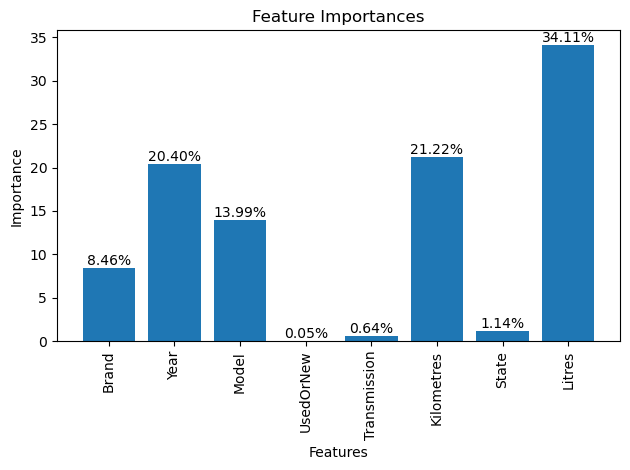

In [26]:
fig, ax = plt.subplots()
bars = ax.bar(range(len(feature_importances_percentage)), feature_importances_percentage, tick_label=columns_names)

for bar, importance in zip(bars, feature_importances_percentage):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{importance:.2f}%', ha='center', va='bottom')

plt.title('Feature Importances')
plt.xlabel('Features')
plt.xticks(rotation='vertical')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

## 3.Random Forest Regressor Model

In [27]:
# loading the Random Forest Regressor Model
random_forest_reg = RandomForestRegressor(random_state=0)
random_forest_reg.fit(X, y.values)

RandomForestRegressor(random_state=0)

In [28]:
y_pred = random_forest_reg.predict(X)

In [29]:
score = random_forest_reg.score(X, y, sample_weight=None)
r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
std = np.std(y)

# Print relevant metrics.
print(f"The score is {score}.")
print(f"The r2 is {r2}.")
print(f"The mean squared error is {mse}.")
print(f"The root mean squared error is {rmse}.")
print(f"The standard deviation is {std}.")

The score is 0.9677013616592776.
The r2 is 0.9677013616592776.
The mean squared error is 24202772.140073214.
The root mean squared error is 4919.631301233174.
The standard deviation is 27374.137808492207.


In [30]:
feature_importances = random_forest_reg.feature_importances_
feature_importances_percentage = feature_importances * 100
columns_names = ['Brand', 'Year', 'Model', 'UsedOrNew', 'Transmission', 'Kilometres', 'State', 'Litres']
for i, importance in enumerate(feature_importances_percentage):
    print(f"{columns_names[i]}: {importance:.2f}%")

Brand: 7.59%
Year: 21.29%
Model: 10.26%
UsedOrNew: 0.09%
Transmission: 0.72%
Kilometres: 21.23%
State: 1.61%
Litres: 37.22%


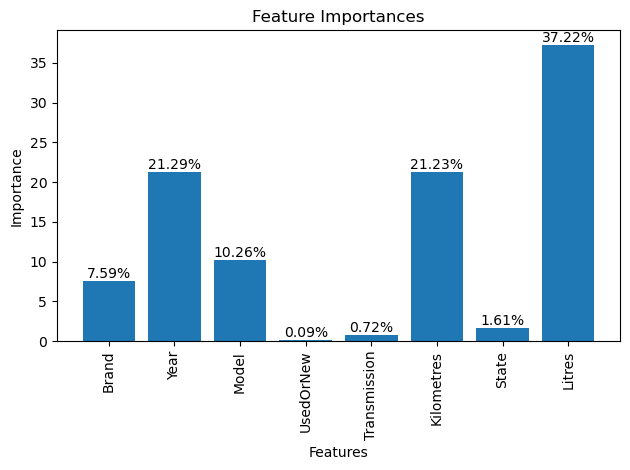

In [31]:
fig, ax = plt.subplots()
bars = ax.bar(range(len(feature_importances_percentage)), feature_importances_percentage, tick_label=columns_names)

for bar, importance in zip(bars, feature_importances_percentage):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{importance:.2f}%', ha='center', va='bottom')

plt.title('Feature Importances')
plt.xlabel('Features')
plt.xticks(rotation='vertical')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

# Testing model with a new inputted value

In [32]:
# Testing model to make a prediction with inputted values
X = np.array([["Nissan", 2009, "Navara", "USED", "Automatic", 190000, "VIC", 2.5]])

In [33]:
X[:, 0] = le_brand.transform(X[:,0])
X[:, 1] = X[0,1]
X[:, 2] = le_model.transform(X[:,2])
X[:, 3] = le_used.transform(X[:,3])
X[:, 4] = le_transmission.transform(X[:,4])
X[:, 5] = X[0,5]  
X[:, 6] = le_state.transform(X[:,6]) 
X[:, 7] = X[0,7]       
X = X.astype(float)
X

array([[1.600e+01, 2.009e+03, 4.370e+02, 1.000e+00, 0.000e+00, 1.900e+05,
        5.000e+00, 2.500e+00]])

In [34]:
y_pred = dec_tree_reg.predict(X)
y_pred_1 = random_forest_reg.predict(X)

print(f"The price predicted usig Decision Tree Regressor Model is: {y_pred}")
print(f"The price predicted usig Random Forest Regressor Model is: {y_pred_1}")

The price predicted usig Decision Tree Regressor Model is: [16999.]
The price predicted usig Random Forest Regressor Model is: [15992.26]


# Saving models to use them on the website

## Decision Tree Regressor Model

In [35]:
data = {"model": dec_tree_reg, "le_brand": le_brand, "le_model": le_model, 
        "le_used": le_used, "le_transmission": le_transmission, "le_state": le_state}
with open('Pickle-files/saved_steps.pkl', 'wb') as file:
    pickle.dump(data, file)

In [36]:
with open('Pickle-files/saved_steps.pkl', 'rb') as file:
    data = pickle.load(file)

dec_tree_reg = data["model"]
le_brand = data["le_brand"]
le_model = data["le_model"]
le_used = data["le_used"]
le_transmission = data["le_transmission"]
le_state = data["le_state"]

In [37]:
y_pred = dec_tree_reg.predict(X)
y_pred

array([16999.])

## Random Forest Regressor Model

In [38]:
data_1 = {"model": random_forest_reg, "le_brand": le_brand, "le_model": le_model, 
        "le_used": le_used, "le_transmission": le_transmission, "le_state": le_state}
with open('Pickle-files/random_model_steps.pkl', 'wb') as file:
    pickle.dump(data_1, file)

In [39]:
with open('Pickle-files/random_model_steps.pkl', 'rb') as file:
    data_1 = pickle.load(file)

random_forest_reg = data_1["model"]
le_brand = data_1["le_brand"]
le_model = data_1["le_model"]
le_used = data_1["le_used"]
le_transmission = data_1["le_transmission"]
le_state = data_1["le_state"]

In [40]:
y_pred_1 = random_forest_reg.predict(X)
y_pred_1

array([15992.26])

### Additional cleaning for the menu "Model" on the website

In [41]:
# Cleaning dataset to filter models by brand on the website
columns_to_drop = ['Price', 'Year', 'UsedOrNew', 'Transmission', 'Kilometres', 'State', 'Litres']
brand_model = brand_model.drop(columns=columns_to_drop)
brand_model.tail()

,Brand,Model
13953,Nissan,Navara
13954,Hyundai,I30
13955,Nissan,Qashqai
13956,Mercedes-Benz,GLC250
13957,Mercedes-Benz,C200


In [42]:
brand_model = brand_model.drop_duplicates(subset='Model', keep='first').sort_values(by=['Brand', 'Model'])
#brand_model = brand_model[brand_model['Brand'] != 'Other']
unique_brands = brand_model.reset_index(drop=True)
unique_brands

,Brand,Model
0,Audi,A1
1,Audi,A3
2,Audi,A4
3,Audi,A5
4,Audi,A6
...,...,...
623,Volkswagen,T-Cross
624,Volkswagen,T-ROC
625,Volkswagen,Tiguan
626,Volkswagen,Touareg


In [43]:
unique_brands.to_csv('Resources/unique_brands.csv', index=False)